We will compare what kinds of aspects appear in the reviews of listings in Athens as well as three islands (Santorini, Mykonos and Rhodes). We will contrast the city vs islands aspects using wordclouds for each case.

Note that data for islands can be found in the `south_aegean` region of `InsideAirbnb` website. While this includes several islands, we kept only Santorini, Mykonos and Rhodes as the three with most available data.

## Load data

In [2]:
import os
import numpy as np
import pandas as pd
from time import time
from utils import aspect_tools
from collections import Counter
import wordcloud
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

data_dir = "/home/stavros/DATA/AirbnbReviews"
area_dir = os.path.join(data_dir, "athens")

In [3]:
area = "south_aegean"
area_dir = os.path.join(data_dir, area)

reviews = {"Athens": pd.read_pickle(os.path.join(data_dir, "athens", "reviews_with_aspects_379118samples.pkl")),
           "Santorini": pd.read_pickle(os.path.join(area_dir, "reviews_with_aspects_Santorini_100266samples.pkl")),
           "Mykonos": pd.read_pickle(os.path.join(area_dir, "reviews_with_aspects_Mykonos_40866samples_sentiment.pkl")),
           "Rhodes": pd.read_pickle(os.path.join(area_dir, "reviews_with_aspects_Rhodes_25566samples_sentiment.pkl"))}

# Keep only reviews where we could identify aspects
for k, r in reviews.items():
    reviews[k] = r[pd.notnull(r["aspects"])]

Check how many reviews we have for each location

In [4]:
for k, r in reviews.items():
    print(k, len(r))

Athens 294403
Santorini 83875
Mykonos 33949
Rhodes 18219


In [5]:
aspects = {k: aspect_tools.collect_aspects(r.aspects) for k, r in reviews.items()}
aspects = {k: aspect_tools.make_aspects_single_words(a) for k, a in aspects.items()}

## Merge similar words using pretrained `word2vec`

In [6]:
import gensim
google_vec_file = os.path.join(data_dir, "GoogleNews-vectors-negative300.bin.gz")
word2vec = gensim.models.KeyedVectors.load_word2vec_format(google_vec_file, binary=True, limit=200000)

In [7]:
distance_matrices = {k: aspect_tools.DistanceMatrix.calculate(word2vec, a, min_appearances=2)
                     for k, a in aspects.items()}

Calculating matrix with 4333 words.
Calculating matrix with 2991 words.
Calculating matrix with 1772 words.
Calculating matrix with 1439 words.


In [8]:
word_maps = {k: m.word_replacement_map(cut_off=0.5) for k, m in distance_matrices.items()}

In [9]:
def merge_aspects(aspects, word_map):
    merged_aspects = Counter()
    for w, v in aspects.items():
        if w in word_map:
            merged_aspects[word_map[w]] += v
    return merged_aspects

## Word clouds

We will generate word clouds for aspects that appear in the city and in the three islands (Santorini, Mykonos and Rhodes)

In [11]:
merged_aspects = {k: merge_aspects(a, word_maps[k]) for k, a in aspects.items()}

city_aspects = merged_aspects["Athens"]
island_aspects = merged_aspects["Santorini"] + merged_aspects["Mykonos"] + merged_aspects["Rhodes"]

n = len(reviews["Athens"])
city_aspects_normalized = Counter({k: v / n for k, v in city_aspects.items()})
n = len(reviews["Santorini"]) + len(reviews["Mykonos"]) + len(reviews["Rhodes"])
island_aspects_normalized = Counter({k: v / n for k, v in island_aspects.items()})

all_aspects = city_aspects_normalized + island_aspects_normalized

In [13]:
cut_off = 0.05 # Exclude words that appear in >5% of reviews in city and islands
city_words, island_words = Counter(), Counter()
for word, _ in all_aspects.most_common():
    if island_aspects_normalized[word] > cut_off and city_aspects_normalized[word] > cut_off:
        continue
    if island_aspects_normalized[word] > city_aspects_normalized[word]:
        island_words[word] = island_aspects[word]
    else:
        city_words[word] = city_aspects[word]
        
print("Island words:", len(island_words))
print("City words:", len(city_words))

Island words: 1184
City words: 1315


Just for fun: Use the city and island map as the word cloud background/mask

In [14]:
from PIL import Image
def separate_earth_and_ocean(image_file: str, ocean_color: np.ndarray = None):
    true_image = np.array(Image.open(image_file))
    # remove last channel that is full of 255 (for some reason I don't know)
    true_image = true_image[:, :, :-1]
    
    full_ocean = np.array(np.prod(true_image.shape[:2]) * [true_image[-1, -1]])
    full_ocean = full_ocean.reshape(true_image.shape)

    oceanx, oceany, _ = np.where(true_image == full_ocean)
    earthx, earthy, _ = np.where(true_image != full_ocean)
        
    ocean_only = np.copy(true_image)
    ocean_only[earthx, earthy] = 255 * np.ones(true_image[earthx, earthy].shape)
    if ocean_color is not None:
        ocean_only[oceanx, oceany] = ocean_color
    
    earth_only = np.copy(true_image)
    earth_only[oceanx, oceany] = 255 * np.ones(true_image[oceanx, oceany].shape)

    return earth_only, ocean_only

island_earth, island_ocean = separate_earth_and_ocean(os.path.join(data_dir, "islands.png"))
city_earth, city_ocean = separate_earth_and_ocean(os.path.join(data_dir, "athens.png"))

Generate wordclouds

In [16]:
island_wc = wordcloud.WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA",
                                width=800, height=600,
                                colormap="twilight",
                                max_words=200, 
                                max_font_size=200,
                                mask=island_earth,
                                random_state=42).generate_from_frequencies(island_words)

city_wc = wordcloud.WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA",
                              width=800, height=600,
                              colormap="twilight",
                              max_words=200, 
                              max_font_size=100, 
                              mask=city_earth,
                              random_state=42).generate_from_frequencies(city_words)

# Plot 1

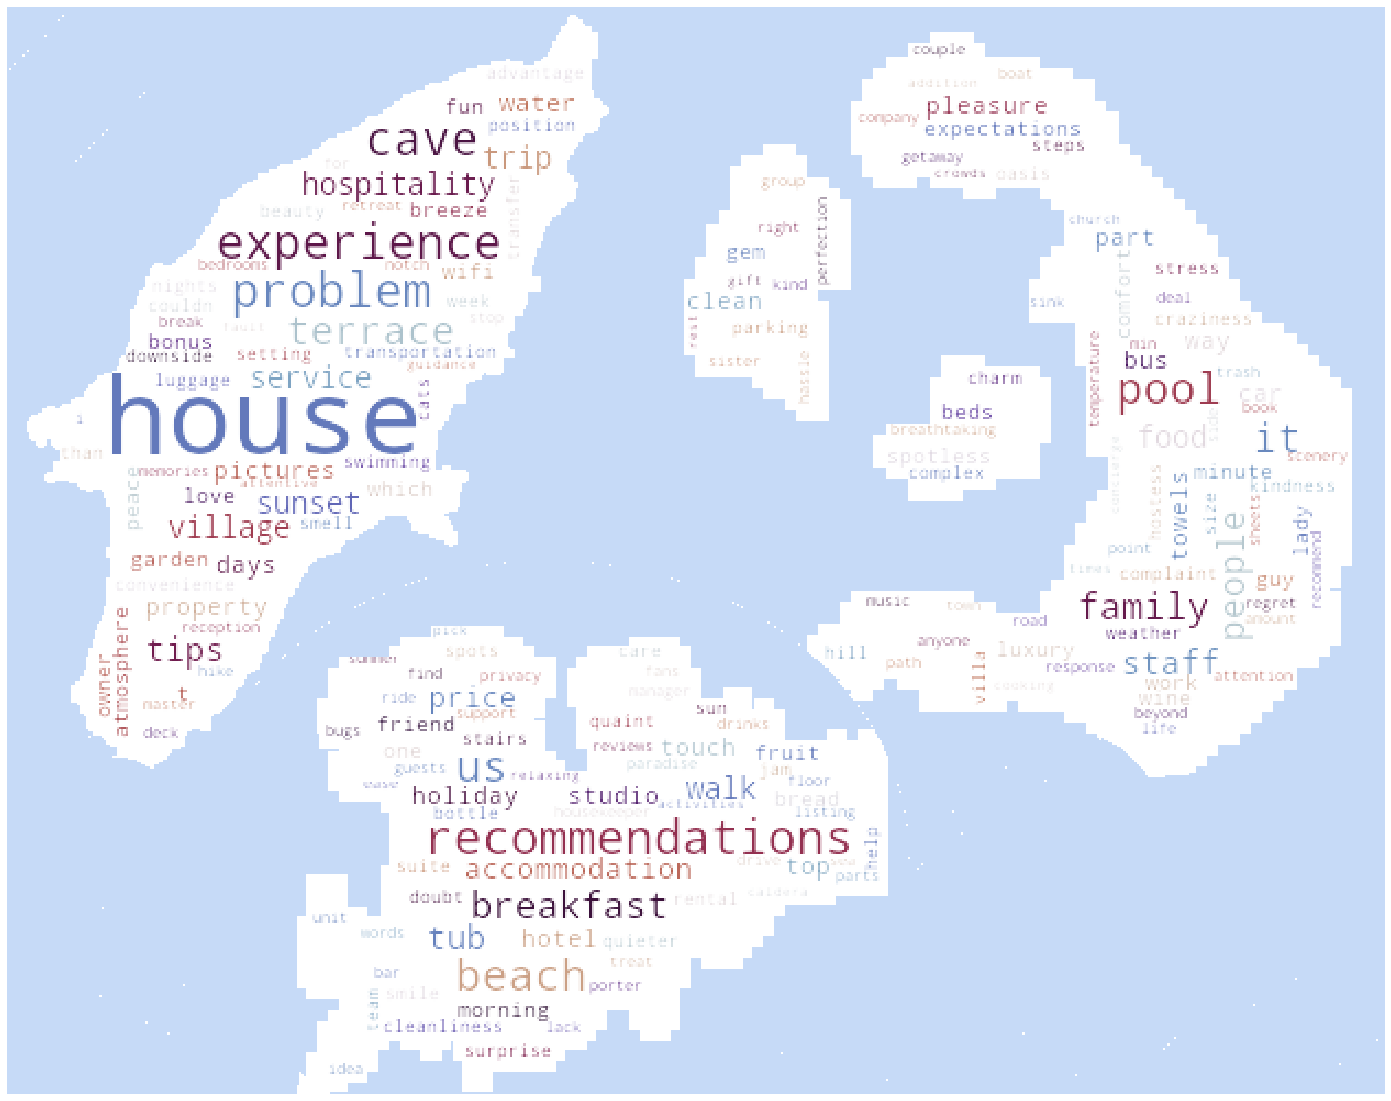

In [17]:
plt.figure(figsize=(30, 20))
plt.imshow(island_ocean)
plt.imshow(island_wc)
plt.axis("off")
plt.show()

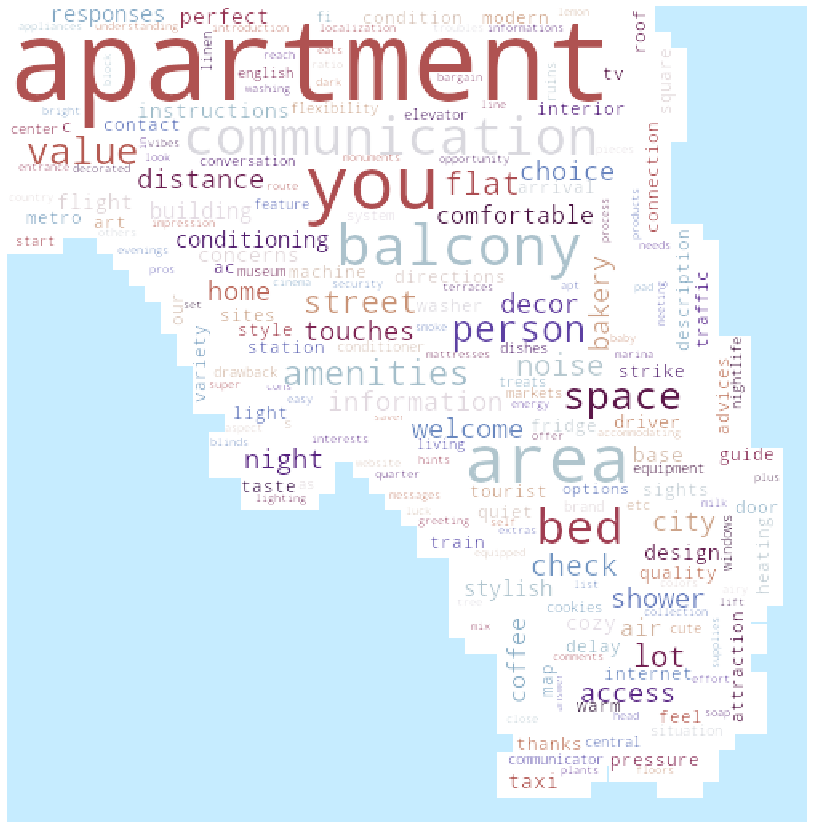

In [18]:
plt.figure(figsize=(25, 15))
plt.imshow(city_ocean)
plt.imshow(city_wc)
plt.axis("off")
plt.show()

* As expected words like `beach` and `pool` appear in the islands whereas words like `area` appear in the city.
* We also see that in the islands people tend to rent mostly full houses while in the city single apartments are a more common option. 
* The appearance of the word `breakfast` in islands hints that actual hotels (with a restaurant that offers breakfast) may use Airbnb to sell their rooms, in contrast to the original Airbnb purpose which would allow people to rent their apartments for short term. More careful analysis shows that this is particularly true for Santorini.